<h1 ><big><center>Object recognition and computer vision 2019/2020</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 3: Birds classification (kaggle challenge)</center></big></h2>

**STUDENT**:  Raphael Reme

**EMAIL**:  raphael.reme@telecom-paristech.fr

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import datasets, transforms

### Handle data

In [7]:
try:
    # You need to upload the dataset in the drive
    from google.colab import drive
    drive.mount('/content/drive')
    data_location = "/content/drive/My Drive/datasets/mva-recvis-2020"
    IN_COLAB = True
except:
    # You need to download the dataset locally.
    data_location = "data/mva-recvis-2020"
    IN_COLAB = False

In [4]:
import random

class GaussianNoise:
    """Add randomly a gaussian noise.

    The mean for each image is mean.
    The standart deviation for each image is draw from an uniform (0, std).

    Applied with a probiblity p.
    """
    def __init__(self, mean, std, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if random.uniform(0, 1) < self.p:
            return tensor + torch.normal(self.mean, random.uniform(0, self.std), tensor.size(), device=tensor.device)
        return tensor


class CorrectRatio:
    """Correct the ratio of an image by cropping it on its main axis."""
    def __init__(self, threshold = 1.2):
        self.threshold = threshold

    def __call__(self, tensor):
        height = tensor.shape[1]
        width = tensor.shape[2]
        if width > self.threshold * height:
            return transforms.CenterCrop((height, int(self.threshold*height)))(tensor)
        if height > self.threshold * width:
            return transforms.CenterCrop((int(self.threshold*width), width))(tensor)
        return tensor


class BirdCropper:
    """Crop around the bird thanks to a bird detection model

    Will also perform the correctRatio task. If no bird is found it will just apply CorrectRatio.
    """
    BIRD_CLASS = 16
    detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    detector.eval()

    def __init__(self, device, detection_threshold=0.9, alpha=1.1, ratio_threshold=1.2):
        self.device = device
        self.detection_threshold = detection_threshold
        self.alpha = alpha
        self.ratio_threshold = ratio_threshold
        self.default_operator = CorrectRatio(ratio_threshold)

    def __call__(self, tensor):
        with torch.no_grad():
            detections = self.detector.to(device)(tensor.view(-1, *tensor.shape).to(device))[0]

        for score, label, box in zip(detections["scores"], detections["labels"], detections["boxes"]):
            if score < self.detection_threshold:
                break
            if label != self.BIRD_CLASS:
                continue
            H, W = tensor.shape[1], tensor.shape[2]
            # Found the "main" bird. Compute the Real box to crop
            # Extend with alpha and secure the ratio
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = x1.item(), y1.item(), x2.item(), y2.item()
            if not (x1 < x2 <= W and y1 < y2 <= H):
                x2 = min(x2, W)
                y2 = min(y2, H)
                if not (x1 < x2 <= W and y1 < y2 <= H):
                    print(x1, x2, W)
                    print(y1, y2, H)
                    raise Exception
            mid_x = 0.5 * (x1 + x2)
            mid_y = 0.5 * (y1 + y2)

            width = self.alpha * (x2 - x1)
            height = self.alpha * (y2 - y1)
            # W > 1.2 H => H < W/1.2
            # W = 1.2 H => H = W/1.2
            # Get the larger bounding box of the good ratio
            height = max(height, width/self.ratio_threshold)
            width = max(width, height/self.ratio_threshold)

            # Could deform a little bit our ratio. But let's forget about it!
            x1 = max(0, int(mid_x - width/2))
            x2 = min(W-1, int(mid_x + width/2))
            y1 = max(0, int(mid_y - height/2))
            y2 = min(H-1, int(mid_y + height/2))
            return tensor[:, y1:y2+1, x1:x2+1]
        return self.default_operator(tensor)


class ListDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (List[Tuple[X, Y]]) 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        if self.transform is not None:
            return self.transform(X), y
        return X, y

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/raph/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
14.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

42.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

71.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set 

In [12]:
# Data re-split correctly and randomly the train data.

FORCE = False

dataset_name = "bird_dataset"
dataset_correct_name = "bird_dataset_corrected"

# Do not run it no reason.
if os.path.exists(f"{data_location}/{corrected_dataset_name}") and not FORCE:
    data_location = f"{data_location}/{corrected_dataset_name}"
    raise Exception("No need to run this cell again!")

def split_by_cls(samples, train_size=0.8):
    """Split samples according to their class

    It will keep `train_size` of each class for training.

    Args:
        samples (List[Tuple[X, Y]]): Each sample is a tuple. The first part is the data,
          the second one is the class. 
        train_size (float): Proportion of calls used for training.

    Returns:
        List[Tuple[X, Y]], List[Tuple[X, Y]]: Training data, validation data.
    """
    classes = {}

    for x, cls in samples:
        if not classes.get(cls):
            classes[cls] = []
        classes[cls].append((x, cls))

    train, val = [], []
    for cls in classes:
        x_train, x_val, y_train, y_val = train_test_split(
            *list(zip(*classes[cls])), train_size=train_size,
        )
        train.extend(list(zip(x_train, y_train)))
        val.extend(list(zip(x_val, y_val)))
    return train, val

train_set = datasets.ImageFolder(f"{data_location}/{dataset_name}/train_images")
val_set = datasets.ImageFolder(f"{data_location}/{dataset_name}/val_images")
test_set = datasets.ImageFolder(f"{data_location}/{dataset_name}/test_images")

train, val = split_by_cls(train_set.imgs + val_set.imgs)

print(f"Initial split: train: {len(train_set)}, val: {len(val_set)}")
print(f"Corrected split: train: {len(train)}, val: {len(val)}")

# Copy the split in another location
data_location = f"{data_location}/{corrected_dataset_name}"
if os.path.isdir(data_location):
    shutil.rmtree(data_location)
    os.makedirs(data_location)

for file, _ in train:
    cls, file_name = file.split("/")[-2:]
    os.makedirs(f"{data_location}/train_images/{cls}", exist_ok=True)
    with open(file, "rb") as f_r:
        with open(f"{data_location}/train_images/{cls}/{file_name}", "wb") as f_w:
            f_w.write(f_r.read())

for file, _ in val:
    cls, file_name = file.split("/")[-2:]
    os.makedirs(f"{data_location}/val_images/{cls}", exist_ok=True)
    with open(file, "rb") as f_r:
        with open(f"{data_location}/val_images/{cls}/{file_name}", "wb") as f_w:
            f_w.write(f_r.read())

for file, _ in test_set.imgs:
    cls, file_name = file.split("/")[-2:]
    os.makedirs(f"{data_location}/test_images/{cls}", exist_ok=True)
    with open(file, "rb") as f_r:
        with open(f"{data_location}/test_images/{cls}/{file_name}", "wb") as f_w:
            f_w.write(f_r.read())

Initial split: train: 1082, val: 103
Corrected split: train: 945, val: 240


In [14]:
SIZE = (256, 256)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

###### FORMER Data transformers #######
# train_transformer = transforms.Compose([
#     # transforms.Resize((256,256)),
#     # transforms.RandomVerticalFlip(p=0.5),
#     # transforms.RandomPerspective(distortion_scale=0.1, p=0.7, fill=127),
#     transforms.ToTensor(),
#     # CorrectRatio(),
#     BirdCropper(device),
#     transforms.RandomHorizontalFlip(p=0.5),
#     # transforms.Resize(SIZE),
#     transforms.RandomResizedCrop(SIZE, (0.8, 1.0), (0.8, 1.2)),
#     # GaussianNoise(0.0, 0.05, 0.8),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Compatible with pretrained models on ImageNet
#                                  std=[0.229, 0.224, 0.225]),
# ])

# eval_transformer = transforms.Compose([
#     transforms.ToTensor(),
#     # CorrectRatio(),
#     BirdCropper(device),
#     transforms.Resize(SIZE),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Compatible with pretrained models on ImageNet
#                                  std=[0.229, 0.224, 0.225]),
# ])

# train_dataset = datasets.ImageFolder(
#     f"{data_location}/train_images",
#     transform=train_transformer,
# )
# val_dataset = datasets.ImageFolder(
#     f"{data_location}/val_images",
#     transform=eval_transformer,
# )
# test_dataset = datasets.ImageFolder(
#     f"{data_location}/test_images",
#     transform=eval_transformer,
# )

###### LAST Data transformers #######

static_transformer = transforms.Compose([
    transforms.ToTensor(),
    BirdCropper(device, detection_threshold=0.3, alpha=1.5),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Compatible with pretrained models on ImageNet
        std=[0.229, 0.224, 0.225],
    ),
])

train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomResizedCrop(SIZE, (0.8, 1.0), (0.8, 1.2)),
])

eval_transformer = transforms.Resize(SIZE)

train_dataset = ListDataset(
    list(datasets.ImageFolder(
        f"{data_location}/train_images",
        transform=static_transformer,
    )),
    transform=train_transformer,
)

val_dataset = ListDataset(
    list(datasets.ImageFolder(
        f"{data_location}/val_images",
        transform=static_transformer,
    )),
    transform=eval_transformer,
)

test_dataset = ListDataset(
    list(datasets.ImageFolder(
        f"{data_location}/test_images",
        transform=static_transformer,
    )),
    transform=eval_transformer,
)

cuda


In [15]:
batch = 32
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=batch, drop_last=False)

In [16]:
classes = {i: [0, 0] for i in range(20)}

for im, e in train_dataset:
    classes[e][0] += 1
for im, e in val_dataset:
    classes[e][1] += 1

# Val set is kind of unbalance but let's keep it that way for now
classes

{0: [48, 12],
 1: [47, 12],
 2: [48, 12],
 3: [48, 12],
 4: [44, 12],
 5: [48, 12],
 6: [48, 12],
 7: [46, 12],
 8: [46, 12],
 9: [47, 12],
 10: [47, 12],
 11: [48, 12],
 12: [47, 12],
 13: [48, 12],
 14: [47, 12],
 15: [48, 12],
 16: [48, 12],
 17: [48, 12],
 18: [47, 12],
 19: [47, 12]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


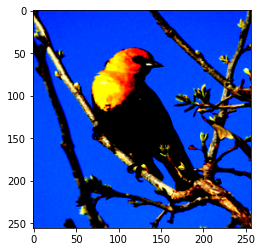

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


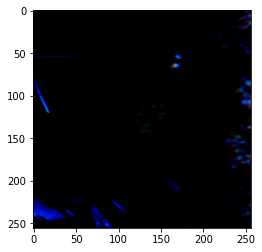

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


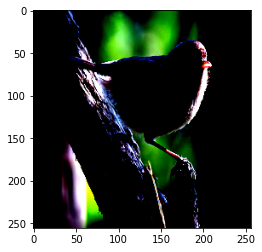

In [17]:
for tensor in next(iter(val_loader))[0][:3]:
    plt.imshow(tensor.permute(1, 2, 0))
    plt.show()

### Models

In [18]:
class ExtendedModel(torch.nn.Module):
    def __init__(self, base, set_grad=False, pretrained=True):
        super().__init__()
        self.name = base
        self.base = getattr(torchvision.models, base)(pretrained=pretrained)
        if callable(set_grad):
            set_grad(self.base)
        else:
            self.base.requires_grad_(set_grad)
        self.base.fc = torch.nn.Linear(self.base.fc.in_features, 20)

    def forward(self, input_):
        return self.base(input_)

def set_grad(net):
    net.requires_grad_(False)
    net.layer4.requires_grad_(True)
    net.layer3.requires_grad_(True)

model = ExtendedModel("resnet50", set_grad=set_grad)
init_weight = model.state_dict()

### Prepare training

In [19]:
model.load_state_dict(init_weight)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
criterion = torch.nn.CrossEntropyLoss(reduction="sum")

In [20]:
def train(model, train_loader, optimizer, criterion, epoch, device, logging_freq=2):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)/data.shape[0]
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % logging_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.0f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item(),
                100. * correct / data.shape[0]))

def validation(model, val_loader, criterion, device):
    model.eval()
    loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        # sum up batch loss
        with torch.no_grad():
            output = model(data)
            loss += criterion(output, target).data.item()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return correct / len(val_loader.dataset)

### Training

In [21]:
!nvidia-smi

Thu Dec  3 19:17:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P0    N/A /  N/A |   2370MiB /  3022MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
epoch = 0

In [24]:
if IN_COLAB:
    EXP_DIR = "/content/drive/My Drive/experiments/RECVIS3"
else:
    EXP_DIR = "experiments"

os.makedirs(f"{EXP_DIR}/{model.name}", exist_ok=True)
best_epoch = 0
best_acc = 0

for i in range(15):
    epoch += 1
    train(model, train_loader, optimizer, criterion, epoch, device, logging_freq=1)
    acc = validation(model, val_loader, criterion, device)
    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc
        if best_acc > 0.8:
            model_file = f"{EXP_DIR}/{model.name}/{epoch}.pth"
            torch.save(model.state_dict(), model_file)
            print(f"Saved model to {model_file}")

Train Epoch: 1 [0/945 (0%)]	Loss: 3.168782	Acc: 0%
Train Epoch: 1 [32/945 (3%)]	Loss: 3.053392	Acc: 6%
Train Epoch: 1 [64/945 (7%)]	Loss: 3.013417	Acc: 3%
Train Epoch: 1 [96/945 (10%)]	Loss: 2.924993	Acc: 9%
Train Epoch: 1 [128/945 (13%)]	Loss: 2.942466	Acc: 9%
Train Epoch: 1 [160/945 (17%)]	Loss: 2.961723	Acc: 3%
Train Epoch: 1 [192/945 (20%)]	Loss: 2.905923	Acc: 6%
Train Epoch: 1 [224/945 (23%)]	Loss: 2.824596	Acc: 6%
Train Epoch: 1 [256/945 (27%)]	Loss: 2.836986	Acc: 12%
Train Epoch: 1 [288/945 (30%)]	Loss: 2.880418	Acc: 9%
Train Epoch: 1 [320/945 (33%)]	Loss: 2.823517	Acc: 19%
Train Epoch: 1 [352/945 (37%)]	Loss: 2.806987	Acc: 22%
Train Epoch: 1 [384/945 (40%)]	Loss: 2.714704	Acc: 22%
Train Epoch: 1 [416/945 (43%)]	Loss: 2.594039	Acc: 28%
Train Epoch: 1 [448/945 (47%)]	Loss: 2.615391	Acc: 38%
Train Epoch: 1 [480/945 (50%)]	Loss: 2.574162	Acc: 44%
Train Epoch: 1 [512/945 (53%)]	Loss: 2.543354	Acc: 47%
Train Epoch: 1 [544/945 (57%)]	Loss: 2.609881	Acc: 31%
Train Epoch: 1 [576/945 (60

Train Epoch: 5 [736/945 (77%)]	Loss: 0.217138	Acc: 100%
Train Epoch: 5 [768/945 (80%)]	Loss: 0.249936	Acc: 97%
Train Epoch: 5 [800/945 (83%)]	Loss: 0.334003	Acc: 88%
Train Epoch: 5 [832/945 (87%)]	Loss: 0.351607	Acc: 94%
Train Epoch: 5 [864/945 (90%)]	Loss: 0.179080	Acc: 97%
Train Epoch: 5 [896/945 (93%)]	Loss: 0.194386	Acc: 97%
Train Epoch: 5 [493/945 (97%)]	Loss: 0.318153	Acc: 94%

Validation set: Average loss: 0.4025, Accuracy: 216/240 (90%)
Train Epoch: 6 [0/945 (0%)]	Loss: 0.306897	Acc: 94%
Train Epoch: 6 [32/945 (3%)]	Loss: 0.163261	Acc: 100%
Train Epoch: 6 [64/945 (7%)]	Loss: 0.132429	Acc: 100%
Train Epoch: 6 [96/945 (10%)]	Loss: 0.248329	Acc: 97%
Train Epoch: 6 [128/945 (13%)]	Loss: 0.276175	Acc: 91%
Train Epoch: 6 [160/945 (17%)]	Loss: 0.171027	Acc: 97%
Train Epoch: 6 [192/945 (20%)]	Loss: 0.153579	Acc: 97%
Train Epoch: 6 [224/945 (23%)]	Loss: 0.147171	Acc: 100%
Train Epoch: 6 [256/945 (27%)]	Loss: 0.132374	Acc: 100%
Train Epoch: 6 [288/945 (30%)]	Loss: 0.189453	Acc: 97%
Train

Train Epoch: 10 [480/945 (50%)]	Loss: 0.040490	Acc: 100%
Train Epoch: 10 [512/945 (53%)]	Loss: 0.035435	Acc: 100%
Train Epoch: 10 [544/945 (57%)]	Loss: 0.091702	Acc: 100%
Train Epoch: 10 [576/945 (60%)]	Loss: 0.085918	Acc: 97%
Train Epoch: 10 [608/945 (63%)]	Loss: 0.080509	Acc: 100%
Train Epoch: 10 [640/945 (67%)]	Loss: 0.108263	Acc: 94%
Train Epoch: 10 [672/945 (70%)]	Loss: 0.045004	Acc: 100%
Train Epoch: 10 [704/945 (73%)]	Loss: 0.051369	Acc: 100%
Train Epoch: 10 [736/945 (77%)]	Loss: 0.052693	Acc: 100%
Train Epoch: 10 [768/945 (80%)]	Loss: 0.043530	Acc: 100%
Train Epoch: 10 [800/945 (83%)]	Loss: 0.020531	Acc: 100%
Train Epoch: 10 [832/945 (87%)]	Loss: 0.055377	Acc: 100%
Train Epoch: 10 [864/945 (90%)]	Loss: 0.054573	Acc: 100%
Train Epoch: 10 [896/945 (93%)]	Loss: 0.032097	Acc: 100%
Train Epoch: 10 [493/945 (97%)]	Loss: 0.102275	Acc: 100%

Validation set: Average loss: 0.4303, Accuracy: 215/240 (90%)
Train Epoch: 11 [0/945 (0%)]	Loss: 0.053777	Acc: 100%
Train Epoch: 11 [32/945 (3%)]	

Train Epoch: 15 [128/945 (13%)]	Loss: 0.023067	Acc: 100%
Train Epoch: 15 [160/945 (17%)]	Loss: 0.031948	Acc: 100%
Train Epoch: 15 [192/945 (20%)]	Loss: 0.019228	Acc: 100%
Train Epoch: 15 [224/945 (23%)]	Loss: 0.014795	Acc: 100%
Train Epoch: 15 [256/945 (27%)]	Loss: 0.017090	Acc: 100%
Train Epoch: 15 [288/945 (30%)]	Loss: 0.067765	Acc: 100%
Train Epoch: 15 [320/945 (33%)]	Loss: 0.016489	Acc: 100%
Train Epoch: 15 [352/945 (37%)]	Loss: 0.016171	Acc: 100%
Train Epoch: 15 [384/945 (40%)]	Loss: 0.018529	Acc: 100%
Train Epoch: 15 [416/945 (43%)]	Loss: 0.018066	Acc: 100%
Train Epoch: 15 [448/945 (47%)]	Loss: 0.020208	Acc: 100%
Train Epoch: 15 [480/945 (50%)]	Loss: 0.015714	Acc: 100%
Train Epoch: 15 [512/945 (53%)]	Loss: 0.041498	Acc: 100%
Train Epoch: 15 [544/945 (57%)]	Loss: 0.013674	Acc: 100%
Train Epoch: 15 [576/945 (60%)]	Loss: 0.014529	Acc: 100%
Train Epoch: 15 [608/945 (63%)]	Loss: 0.016485	Acc: 100%
Train Epoch: 15 [640/945 (67%)]	Loss: 0.019747	Acc: 100%
Train Epoch: 15 [672/945 (70%)]

# Load the best model in validation and use to predict on test set

In [26]:
model = ExtendedModel(model.name)
model.load_state_dict(torch.load(f"{EXP_DIR}/{model.name}/{best_epoch}.pth"))

model = model.to(device)

In [27]:
validation(model, val_loader, criterion, device)


Validation set: Average loss: 0.3774, Accuracy: 219/240 (91%)


tensor(0.9125)

In [28]:
files = os.listdir(f"{data_location}/test_images/mistery_category")
predictions = "Id,Category\n"

for f, (data, _) in zip(files, test_dataset):
    data = data.view(-1, *data.size()).to(device)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    predictions += "%s,%d\n" % (f[:-4], pred)

print(predictions[:150])

Id,Category
47f6849caa9f6f62464a0c9a6e80d51f,5
7c7dda90bde492d9f1b4bd3aa2e8de58,17
37f77452e94321c7be2beeb84d381316,18
3e619cc5303b8404c8ee5d595f87fb3


In [30]:
exp_name = f"{model.name}-{best_epoch}-2ll-bird_crop-3Threshold-b100-full-train"

if IN_COLAB:
    OUTPUT_DIR = "/content/drive/My Drive/experiments/RECVIS3/results"
else:
    OUTPUT_DIR = "experiments/results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(f"{OUTPUT_DIR}/{exp_name}.csv", "w") as file:
    file.write(predictions)